In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
from __future__ import division
import matplotlib
import tensorflow.keras as keras
import tensorflow as tf
from pylab import *
import numpy as np
from IPython.display import HTML, display
from scipy.optimize import curve_fit

#import plotly.express as px
#import plotly.express as px
#import plotly.graph_objects as go
pass

In [3]:
# Define some plotting styles that we will use.
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}

# 1 simulator

In [4]:
def Hill_equation(x,h,K):
    return x**h/(K**h+x**h)
Hill_equation = np.vectorize(Hill_equation)

def Bernoulli(x,p):
    if x > p:
        return 0
    else:
        return 1
Bernoulli=np.vectorize(Bernoulli)

def cal_p(m,l,h,K): #the ZL2010 model
    return (Hill_equation(m/l,h,K))**m
cal_p = np.vectorize(cal_p) 

#parameters from the experiments
h = 2.07;
K = 1.17;

#np.random.seed(2)

# 2 generate training and testing datasets

In [31]:
N = 2000;
n_moi = 5;
x_train = np.zeros((n_moi*N,2));
y_train = np.zeros(n_moi*N);
z_train = np.zeros(n_moi*N);

for m in range(1,6):
    l_list = np.random.lognormal(0, 0.28, N)
    x_train[(m-1)*N:m*N,0] = np.repeat(m,N);
    x_train[(m-1)*N:m*N,1] = l_list;
    p_list = cal_p(m,l_list,h,K);
    y_train[(m-1)*N:m*N] = Bernoulli(np.random.uniform(0,1,N),p_list);
    z_train[(m-1)*N:m*N] = p_list;
     

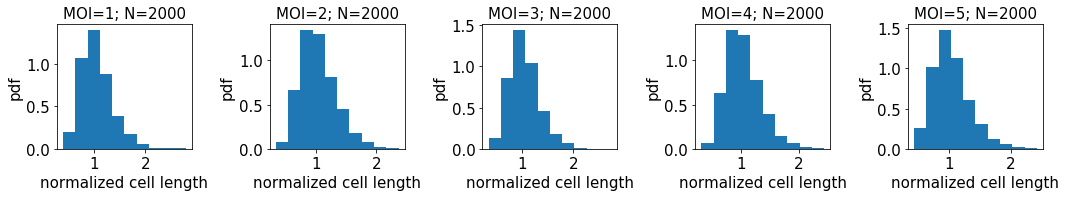

In [33]:
matplotlib.rcParams.update({"figure.figsize": (15,3)})
for i in range(1,6):
    subplot(1,5,i)
    hist(x_train[(i-1)*N:i*N,1],density=True)
    ylabel('pdf');xlabel('normalized cell length')
    title('MOI='+str(i)+'; N=2000')
tight_layout()

In [47]:
N = 2000;
n_moi = 5;
x_test = np.zeros((n_moi*N,2));
y_test = np.zeros(n_moi*N);
z_test = np.zeros(n_moi*N);

for m in range(6,11):
    l_list = np.random.lognormal(0, 0.28, N)
    x_test[(m-6)*N:(m-5)*N,0] = np.repeat(m,N);
    x_test[(m-6)*N:(m-5)*N,1] = l_list;
    p_list = cal_p(m,l_list,h,K);
    y_test[(m-6)*N:(m-5)*N] = Bernoulli(np.random.uniform(0,1,N),p_list);
    z_test[(m-6)*N:(m-5)*N] = p_list;
     

In [48]:
#x_train1 = tf.keras.utils.normalize(x_train, axis=1)
#x_test1 = tf.keras.utils.normalize(x_test, axis=1)

# 3 Perform training

In [55]:
x_train2 = x_train
y_train2 = y_train
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(200, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(200, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(200, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(200, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(200, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train2, y_train2, epochs=5)

Train on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 2s 175us/sample - loss: 0.6132 - accuracy: 0.6740 - los
Epoch 2/5
10000/10000 [==============================] - 1s 134us/sample - loss: 0.5987 - accuracy: 0.6808
Epoch 3/5
10000/10000 [==============================] - 1s 105us/sample - loss: 0.5968 - accuracy: 0.6846
Epoch 4/5
10000/10000 [==============================] - 1s 112us/sample - loss: 0.5947 - accuracy: 0.6823
Epoch 5/5
10000/10000 [==============================] - 2s 152us/sample - loss: 0.5935 - accuracy: 0.6817


## 3.1 Mean absolute error saturates after 5 rounds of traning

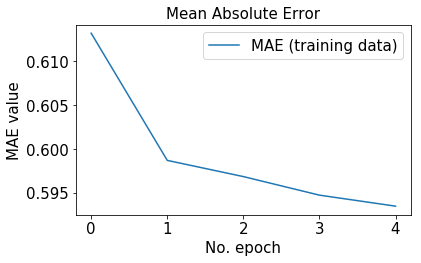

In [68]:
# Plot history: MAE
matplotlib.rcParams.update({"figure.figsize": (6,3.5)})
plt.plot(history.history['loss'], label='MAE (training data)')
#plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('Mean Absolute Error')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

## 3.2 training and testing performance

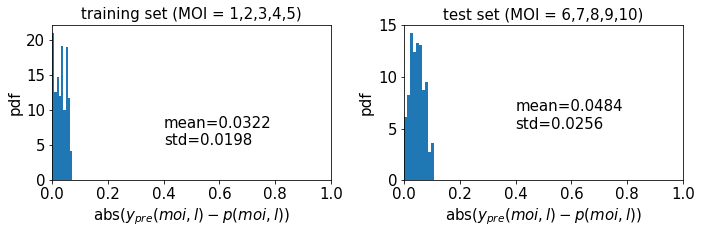

In [57]:
p_diff1 = abs(model.predict(x_train2).flatten()-z_train)
p_diff2 = abs(model.predict(x_test).flatten()-z_test)

matplotlib.rcParams.update({"figure.figsize": (10,3.5)})
subplot(1,2,1)
title('training set (MOI = 1,2,3,4,5)')
hist(p_diff1,density=True)
ylabel('pdf');xlabel(r'abs($y_{pre}(moi,l)-p(moi,l)$)')
xlim((0,1))
text(0.4,5,'mean='+str(round(np.mean(p_diff1),4))+'\n'+'std='+str(round(np.std(p_diff1),4)))

subplot(1,2,2)
title('test set (MOI = 6,7,8,9,10)')
hist(p_diff2,density=True)
ylabel('pdf');xlabel(r'abs($y_{pre}(moi,l)-p(moi,l)$)')
xlim((0,1))
text(0.4,5,'mean='+str(round(np.mean(p_diff2),4))+'\n'+'std='+str(round(np.std(p_diff2),4)))

tight_layout()

# 4 Comparision to ZL2010 model
## 4.1 predicting probablity of lysogeny based on MOI

In [58]:
def Hill_fit(xx,y):
    popt, pcov = curve_fit(Hill_equation, xx, y, p0=[1,1])
    return (popt[0],popt[1])

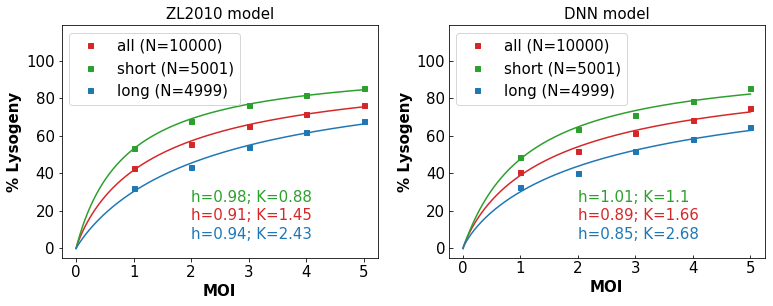

In [67]:
N_a = 0; N_s = 0; N_l = 0;  #counts

p_m = np.zeros((5,3)); p_e = np.zeros((5,3)); h_ = np.zeros(5); K_ = np.zeros(5)
p_m2 = np.zeros((5,3)); p_e2 = np.zeros((5,3)); h_2 = np.zeros(5); K_2 = np.zeros(5)

l_all = np.zeros((6,2000)) #lengths

for m in range(1,6):
    l_list = np.random.lognormal(0, 0.28, 2000)
    l_all[m,:] = l_list; 
    l_long = l_list[l_list>1.0]; N_l += len(l_long);
    l_short = l_list[l_list<=1.0]; N_s += len(l_short);
    m_long = np.repeat(m,len(l_long)); x_long = np.vstack((m_long,l_long)).T; 
    m_short = np.repeat(m,len(l_short)); x_short = np.vstack((m_short, l_short)).T
    m_all = np.repeat(m, 2000); x_all = np.vstack((m_all, l_list)).T
    
    t_a = model.predict(x_all).flatten()
    t_s = model.predict(x_short).flatten()
    t_l = model.predict(x_long).flatten()

    p_m[m-1,0] = np.mean(t_a); #p_e[m-1,0] = np.std(t_a);
    p_m[m-1,1] = np.mean(t_s); #p_e[m-1,1] = np.std(t_s);
    p_m[m-1,2] = np.mean(t_l); #p_e[m-1,2] = np.std(t_l);
    
    p_m2[m-1,0] = np.mean(cal_p(m,l_list,h,K));
    p_m2[m-1,1] = np.mean(cal_p(m,l_short,h,K));
    p_m2[m-1,2] = np.mean(cal_p(m,l_long,h,K));
    
N_a = N_s + N_l
xx = np.array(range(0,6))
(h_[0], K_[0]) = Hill_fit(xx[1:],p_m[:,0])
(h_[1], K_[1]) = Hill_fit(xx[1:],p_m[:,1])
(h_[2], K_[2]) = Hill_fit(xx[1:],p_m[:,2])

(h_2[0], K_2[0]) = Hill_fit(xx[1:],p_m2[:,0])
(h_2[1], K_2[1]) = Hill_fit(xx[1:],p_m2[:,1])
(h_2[2], K_2[2]) = Hill_fit(xx[1:],p_m2[:,2])


xxx = np.linspace(0,5,1000)
##################plot####################
matplotlib.rcParams.update({"figure.figsize": (11,4.5)})
fig, ax = plt.subplots()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plotStyles={"markersize":5,"markeredgewidth":1.0,"linewidth":2.0}

colors = ['tab:red','tab:green','tab:blue']
N_ = [N_a, N_s, N_l];
label_ = ['all','short','long']
y_loc = [15,25,5]

subplot(1,2,1)
title('ZL2010 model')
for i in range(0,3):
    plot(xx[1:],p_m2[:,i]*100, 's',color=colors[i],label=label_[i]+' (N='+str(N_[i])+')',**plotStyles)
    plot(xxx,Hill_equation(xxx,h_2[i],K_2[i])*100,'-',color=colors[i])
    text(2,y_loc[i],'h='+str(round(h_2[i],2))+'; K='+str(round(K_2[i],2)),color=colors[i])

legend(loc='upper left')
ylim((-5,119))
xlabel('MOI',weight='bold'); ylabel('% Lysogeny',weight='bold')

subplot(1,2,2)
title('DNN model')
for i in range(0,3):
    plot(xx[1:],p_m[:,i]*100, 's',color=colors[i],label=label_[i]+' (N='+str(N_[i])+')',**plotStyles)
    plot(xxx,Hill_equation(xxx,h_[i],K_[i])*100,'-',color=colors[i])
    text(2,y_loc[i],'h='+str(round(h_[i],2))+'; K='+str(round(K_[i],2)),color=colors[i])

legend(loc='upper left')
ylim((-5,119))
xlabel('MOI',weight='bold'); ylabel('% Lysogeny',weight='bold')


tick_params(axis="y",direction="in")
tick_params(axis="x",direction="in")
tight_layout()

#plt.savefig('file_virtual_phage/rre_fig2c.png')
#plt.close()

#display(HTML("<table><tr><td><img src='file_virtual_phage/rre_fig2c.png' width=380></td><td><img src='files/fig2c.png' width=450></td></tr></table>"))
        

## 4.2 predicting probablity of lysogeny based on viral concerntration

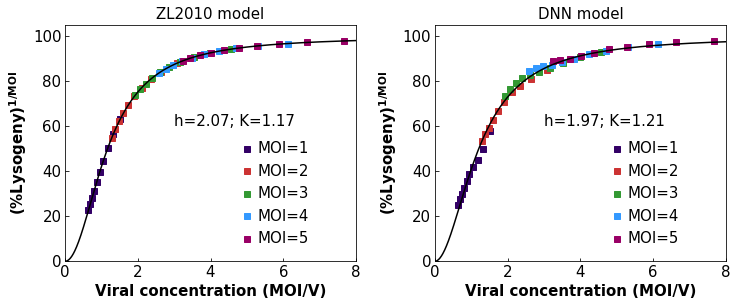

In [66]:
colors = ['#330066','#CC3333','#339933','#3399FF','#990066']

bin_l = [0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
bin_h = [0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6]

x_ = np.array([]); x_m = np.empty((5,),dtype=object)
y_1 = np.array([]); y_m1 = np.empty((5,),dtype=object)
y_2 = np.array([]); y_m2 = np.empty((5,),dtype=object)

for m in range(1,6):
    my_l = np.array(l_all[m,:]);
    x_list = np.array([])
    tmp1 = np.array([])
    tmp2 = np.array([])
    for i in range(0,len(bin_l)):
        indices1 = np.where(my_l>=bin_l[i])[0]
        indices2 = np.where(my_l<bin_h[i])[0]
        indices = list(set(indices1) & set(indices2))
        length = my_l[indices]
        moi = np.repeat(m,len(length))
        x_list = np.append(x_list, m/np.mean(my_l[indices]))
        tmp1 = np.append(tmp1, np.mean(model.predict(np.vstack((moi,length)).T).flatten())**(1/m))
        tmp2 = np.append(tmp2, np.mean(cal_p(m,length,h,K))**(1/m));
    x_ = np.append(x_, x_list);
    y_1 = np.append(y_1, tmp1);
    y_2 = np.append(y_2, tmp2);
    x_m[m-1] = x_list;
    y_m1[m-1] = tmp1;
    y_m2[m-1] = tmp2;

(h1,K1) = Hill_fit(x_,y_1)
(h2,K2) = Hill_fit(x_,y_2)

matplotlib.rcParams.update({"figure.figsize": (10.5,4.5)})
subplot(1,2,1)
title('ZL2010 model')
xx = np.linspace(0,8,1000)
for i in range(0,5):
    plot(x_m[i], y_m2[i]*100, 's', color=colors[i])
plot(xx,Hill_equation(xx,h2,K2)*100,color='black')
xlim((0,8));ylim((0,105))
xlabel('Viral concentration (MOI/V)',weight='bold'); ylabel(r'$\mathbf{(\% Lysogeny)^{1/MOI}}$',weight='bold')
tick_params(axis="y",direction="in")
tick_params(axis="x",direction="in")
text(3,60,'h='+str(round(h2,2))+'; K='+str(round(K2,2)),color='black')
plot(5,50,'s',color=colors[0]); text(5.3,48,'MOI=1')
plot(5,40,'s',color=colors[1]); text(5.3,38,'MOI=2')
plot(5,30,'s',color=colors[2]); text(5.3,28,'MOI=3')
plot(5,20,'s',color=colors[3]); text(5.3,18,'MOI=4')
plot(5,10,'s',color=colors[4]); text(5.3,8,'MOI=5')

subplot(1,2,2)
title('DNN model')
xx = np.linspace(0,8,1000)
for i in range(0,5):
    plot(x_m[i], y_m1[i]*100, 's', color=colors[i])
plot(xx,Hill_equation(xx,h1,K1)*100,color='black')
xlim((0,8));ylim((0,105))
xlabel('Viral concentration (MOI/V)',weight='bold'); ylabel(r'$\mathbf{(\% Lysogeny)^{1/MOI}}$',weight='bold')
tick_params(axis="y",direction="in")
tick_params(axis="x",direction="in")
text(3,60,'h='+str(round(h1,2))+'; K='+str(round(K1,2)),color='black')
plot(5,50,'s',color=colors[0]); text(5.3,48,'MOI=1')
plot(5,40,'s',color=colors[1]); text(5.3,38,'MOI=2')
plot(5,30,'s',color=colors[2]); text(5.3,28,'MOI=3')
plot(5,20,'s',color=colors[3]); text(5.3,18,'MOI=4')
plot(5,10,'s',color=colors[4]); text(5.3,8,'MOI=5')

tight_layout() 

#plt.savefig('files/re_fig3c.png')
#plt.close()